# Propensity Modelling

I. Loading the Data

II. Feature Engineering

- User Activity Features:
  - Number of Days Active
  - Average time between purchase
  - Cart to Purchase Ratio
  - Wishlist to Purchase Ratio
  - Path to Cart

- Category/SubCategory level Features:
  - Cart to Purchase ratio (Category/SubCategory)
  - Wishlist to Purchase Ratio (Category/SubCategory)
  - Product View to Purchase ratio (Category/SubCategory)

III. Modeling Dataset Creation

IV. Model Building

---

## Loading the Data:

In [1]:
# Importing the necessary Libraries
import pandas as pd
import numpy as np
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
pd.set_option('display.max_colwidth',None)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from datetime import timedelta
import gc 

import warnings 
warnings.filterwarnings('ignore')

In [2]:
# Read the CSV file into a DataFrame and parse the 'DateTime' column as dates
data = pd.read_csv("data/final_customer_data_with_RFM_features.csv", parse_dates=['DateTime'])

# Print the shape
print(data.shape)

data.head()


(2090, 18)


,User_id,Session_id,DateTime,Category,SubCategory,Action,Quantity,Rate,Total Price,Recency,Frequency,Monetary,R,F,M,Group,Score,Loyalty_Level
0,52243841613,d76fde-8bb3-4e00-8c23,2019-01-10 10:20:00,Electronic Appliances,Speakers,first_app_open,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,52243841613,33dfbd-b87a-4708-9857,2019-01-10 10:22:00,Electronic Appliances,Speakers,search,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,57314161118,6511c2-e2e3-422b-b695,2019-01-10 14:00:00,Men's Fashion,Jeans,search,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,57314161118,90fc70-0e80-4590-96f3,2019-01-10 14:07:00,Men's Fashion,Jeans,product_view,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,57314161118,bd7419-2748-4c56-95b4,2019-01-10 14:12:00,Men's Fashion,Jeans,read_reviews,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2090 entries, 0 to 2089
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   User_id        2090 non-null   int64         
 1   Session_id     2090 non-null   object        
 2   DateTime       2090 non-null   datetime64[ns]
 3   Category       2090 non-null   object        
 4   SubCategory    2090 non-null   object        
 5   Action         2090 non-null   object        
 6   Quantity       201 non-null    float64       
 7   Rate           201 non-null    float64       
 8   Total Price    201 non-null    float64       
 9   Recency        1303 non-null   float64       
 10  Frequency      1303 non-null   float64       
 11  Monetary       1303 non-null   float64       
 12  R              1303 non-null   float64       
 13  F              1303 non-null   float64       
 14  M              1303 non-null   float64       
 15  Group          1303 n

In [4]:
# Print the number of unique values in the 'Action' column
print(len(data.Action.value_counts()))

# Standardize 'Action' values to 'read_reviews' if 'read_review' and 'add_to_wishlist' if 'add_to_wishist'
data['Action'] = data['Action'].apply(lambda x: 'read_reviews' if x in ('read_review') else x)
data['Action'] = data['Action'].apply(lambda x: 'add_to_wishlist' if x in ('add_to_wishist') else x)

# Print the number of unique values in the 'Action' column after standardization
print(len(data.Action.value_counts()))


13
11


In [5]:
# Extract date level features from the 'DateTime' column

data['Date'] = data['DateTime'].dt.date  # Extract the date part
data['DayOfWeek'] = data['DateTime'].dt.dayofweek  # Extract the day of the week (0 for Monday, 6 for Sunday)
data['DayOfMonth'] = data['DateTime'].dt.day  # Extract the day of the month


In [6]:
# Create a copy of the DataFrame 'data' and store it in 'df'
df = data.copy()

df.head(3)


,User_id,Session_id,DateTime,Category,SubCategory,Action,Quantity,Rate,Total Price,Recency,Frequency,Monetary,R,F,M,Group,Score,Loyalty_Level,Date,DayOfWeek,DayOfMonth
0,52243841613,d76fde-8bb3-4e00-8c23,2019-01-10 10:20:00,Electronic Appliances,Speakers,first_app_open,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-10,3,10
1,52243841613,33dfbd-b87a-4708-9857,2019-01-10 10:22:00,Electronic Appliances,Speakers,search,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-10,3,10
2,57314161118,6511c2-e2e3-422b-b695,2019-01-10 14:00:00,Men's Fashion,Jeans,search,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-10,3,10


---

## Feature Engineering:

### User Activity Features:

#### Number of Days Active:

In [7]:
# Group data by 'User_id' and count the number of unique dates, then reset the index
temp_days_active = df.groupby('User_id').agg({'Date': 'nunique'}).reset_index()

# Rename the 'Date' column to 'no_of_days_active'
temp_days_active.rename(columns={'Date': 'no_of_days_active'}, inplace=True)

# Print the shape (number of rows and columns) of the DataFrame
print(temp_days_active.shape)

# Display the first 3 rows of the DataFrame
temp_days_active.head(3)


(401, 2)


,User_id,no_of_days_active
0,51443820326,1
1,51448162784,3
2,51455512201,3


#### Average time between purchase:

In [ ]:
# del temp

In [8]:
# Create a copy of the DataFrame 'df' and store it in a new DataFrame 'temp'
temp = df.copy()


In [9]:
# Function to calculate time difference between purchase events
def purch_time_diff(x):
    if len(x) == 2:
        # If there are 2 purchase events, return the difference in days between the 2nd and 1st event
        return (x[1] - x[0]).days

    if len(x) == 3:
        # If there are 3 purchase events, calculate the average time difference between events 1-2 and 2-3
        diff_12 = (x[1] - x[0]).days
        diff_23 = (x[2] - x[1]).days
        return (diff_12 + diff_23) / 2


In [10]:
# Extract purchase dates and create a DataFrame with users and their purchase dates
temp_user_purchase_date = (temp[temp['Action'] == 'purchase']
    .sort_values(by='Date')
    .groupby('User_id')
    .agg({'Date': lambda x: list(x)})
    .reset_index()
)

# Extract the first, second, and third purchase dates, and calculate the average time between purchases
temp_user_purchase_date['purchase1'] = temp_user_purchase_date['Date'].apply(lambda x: x[0])
temp_user_purchase_date['purchase2'] = temp_user_purchase_date['Date'].apply(lambda x: x[1] if len(x) > 1 else 0)
temp_user_purchase_date['purchase3'] = temp_user_purchase_date['Date'].apply(lambda x: x[2] if len(x) > 2 else 0)
temp_user_purchase_date['avg_time_between_purchase'] = temp_user_purchase_date['Date'].apply(purch_time_diff)

# Print the shape (number of rows and columns) of the DataFrame
print(temp_user_purchase_date.shape)

# Display the first few rows of the DataFrame
temp_user_purchase_date.head()


(167, 6)


,User_id,Date,purchase1,purchase2,purchase3,avg_time_between_purchase
0,51448162784,"[2019-06-11, 2019-12-12]",2019-06-11,2019-12-12,0,184.0
1,51455512201,[2019-10-19],2019-10-19,0,0,NaN
2,51462598385,"[2019-10-20, 2019-12-15]",2019-10-20,2019-12-15,0,56.0
3,51463622150,"[2019-10-14, 2019-11-12]",2019-10-14,2019-11-12,0,29.0
4,51465529647,"[2019-12-05, 2019-12-12]",2019-12-05,2019-12-12,0,7.0


In [11]:
gc.collect()

0

#### Cart to Purchase Ratio:

In [12]:
del temp

In [13]:
temp = df.copy()

In [14]:
# Function to calculate purchase ratios for a specific action
def purchase_ratios(action_col='add_to_cart', id_col='User_id', col_name='no_of_carts'):
    # Number of actions for each user
    test1 = (temp[temp['Action'] == action_col]
        .groupby(id_col)
        .agg({'Session_id': 'count'})
        .reset_index()
    )
    test1.rename(columns={'Session_id': col_name}, inplace=True)
    print(test1.shape)

    # Number of purchases for each user
    test2 = temp[temp['Action'] == 'purchase'].groupby(id_col).agg({'Session_id': 'count'}).reset_index()
    test2.rename(columns={'Session_id': 'no_of_purch'}, inplace=True)
    print(test2.shape)

    # Merge the two DataFrames and calculate the action-to-purchase ratio
    test_ratio = pd.merge(test1, test2, on=id_col, how='left')
    test_ratio = test_ratio.fillna(0)
    test_ratio[col_name + '_to_purchase_ratio'] = (test_ratio['no_of_purch'] / test_ratio[col_name])
    print(test_ratio.shape)
    return test_ratio


In [15]:
# Calculate cart-to-purchase ratio for each user
temp_cart_purch_ratio_user = purchase_ratios(action_col='add_to_cart', id_col='User_id', col_name='no_of_carts')

# Print the shape (number of rows and columns) of the resulting DataFrame
print(temp_cart_purch_ratio_user.shape)

# Display the first few rows of the DataFrame
display(temp_cart_purch_ratio_user.head())

# Generate descriptive statistics for the DataFrame
temp_cart_purch_ratio_user.describe()


(240, 2)
(167, 2)
(240, 4)
(240, 4)


,User_id,no_of_carts,no_of_purch,no_of_carts_to_purchase_ratio
0,51448162784,2,2.0,1.000000
1,51455512201,1,1.0,1.000000
2,51462598385,2,2.0,1.000000
3,51463622150,2,2.0,1.000000
4,51465529647,3,2.0,0.666667


,User_id,no_of_carts,no_of_purch,no_of_carts_to_purchase_ratio
count,2.400000e+02,240.000000,240.000000,240.000000
mean,5.396592e+10,1.166667,0.754167,0.614583
std,2.767010e+09,0.405678,0.698162,0.534009
min,5.144816e+10,1.000000,0.000000,0.000000
25%,5.185721e+10,1.000000,0.000000,0.000000
50%,5.231850e+10,1.000000,1.000000,1.000000
75%,5.586744e+10,1.000000,1.000000,1.000000
max,6.030264e+10,3.000000,3.000000,3.000000


In [16]:
gc.collect()

0

#### Wishlist to Purchase Ratio:

In [17]:
del temp

In [18]:
temp = df.copy()

In [19]:
# Calculate click wishlist to purchase ratio for each user
temp_click_wishlist_purch_ratio_user = purchase_ratios(action_col='click_wishlist_page',
                                                      id_col='User_id', col_name='no_of_click_wishlist')

# Print the shape (number of rows and columns) of the resulting DataFrame
print(temp_click_wishlist_purch_ratio_user.shape)

# Display the first few rows of the DataFrame
display(temp_click_wishlist_purch_ratio_user.head())

# Generate descriptive statistics for the DataFrame
temp_click_wishlist_purch_ratio_user.describe()


(191, 2)
(167, 2)
(191, 4)
(191, 4)


,User_id,no_of_click_wishlist,no_of_purch,no_of_click_wishlist_to_purchase_ratio
0,51448162784,1,2.0,2.0
1,51463622150,1,2.0,2.0
2,51465529647,1,2.0,2.0
3,51468519074,1,1.0,1.0
4,51475146821,1,0.0,0.0


,User_id,no_of_click_wishlist,no_of_purch,no_of_click_wishlist_to_purchase_ratio
count,1.910000e+02,191.000000,191.000000,191.000000
mean,5.403865e+10,1.057592,0.492147,0.458988
std,2.800753e+09,0.274978,0.687246,0.644753
min,5.144816e+10,1.000000,0.000000,0.000000
25%,5.182071e+10,1.000000,0.000000,0.000000
50%,5.230498e+10,1.000000,0.000000,0.000000
75%,5.618519e+10,1.000000,1.000000,1.000000
max,6.030264e+10,3.000000,3.000000,2.000000


In [20]:
# Calculate add wishlist to purchase ratio for each user
temp_add_wishlist_purch_ratio_user = purchase_ratios(action_col='add_to_wishlist',
                                                    id_col='User_id', col_name='no_of_add_wishlist')

# Print the shape (number of rows and columns) of the resulting DataFrame
print(temp_add_wishlist_purch_ratio_user.shape)

# Display the first few rows of the DataFrame
display(temp_add_wishlist_purch_ratio_user.head())

# Generate descriptive statistics for the DataFrame
temp_add_wishlist_purch_ratio_user.describe()


(26, 2)
(167, 2)
(26, 4)
(26, 4)


,User_id,no_of_add_wishlist,no_of_purch,no_of_add_wishlist_to_purchase_ratio
0,51463622150,1,2.0,2.00
1,51477448981,2,1.0,0.50
2,51517997197,2,2.0,1.00
3,51526464449,1,2.0,2.00
4,51565158157,4,3.0,0.75


,User_id,no_of_add_wishlist,no_of_purch,no_of_add_wishlist_to_purchase_ratio
count,2.600000e+01,26.000000,26.000000,26.000000
mean,5.295457e+10,1.461538,1.538462,1.214744
std,2.529052e+09,0.760567,0.706018,0.694491
min,5.146362e+10,1.000000,0.000000,0.000000
25%,5.161642e+10,1.000000,1.000000,0.812500
50%,5.175573e+10,1.000000,2.000000,1.000000
75%,5.230051e+10,2.000000,2.000000,2.000000
max,5.953342e+10,4.000000,3.000000,2.000000


In [21]:
gc.collect()

0

#### Path to Cart:

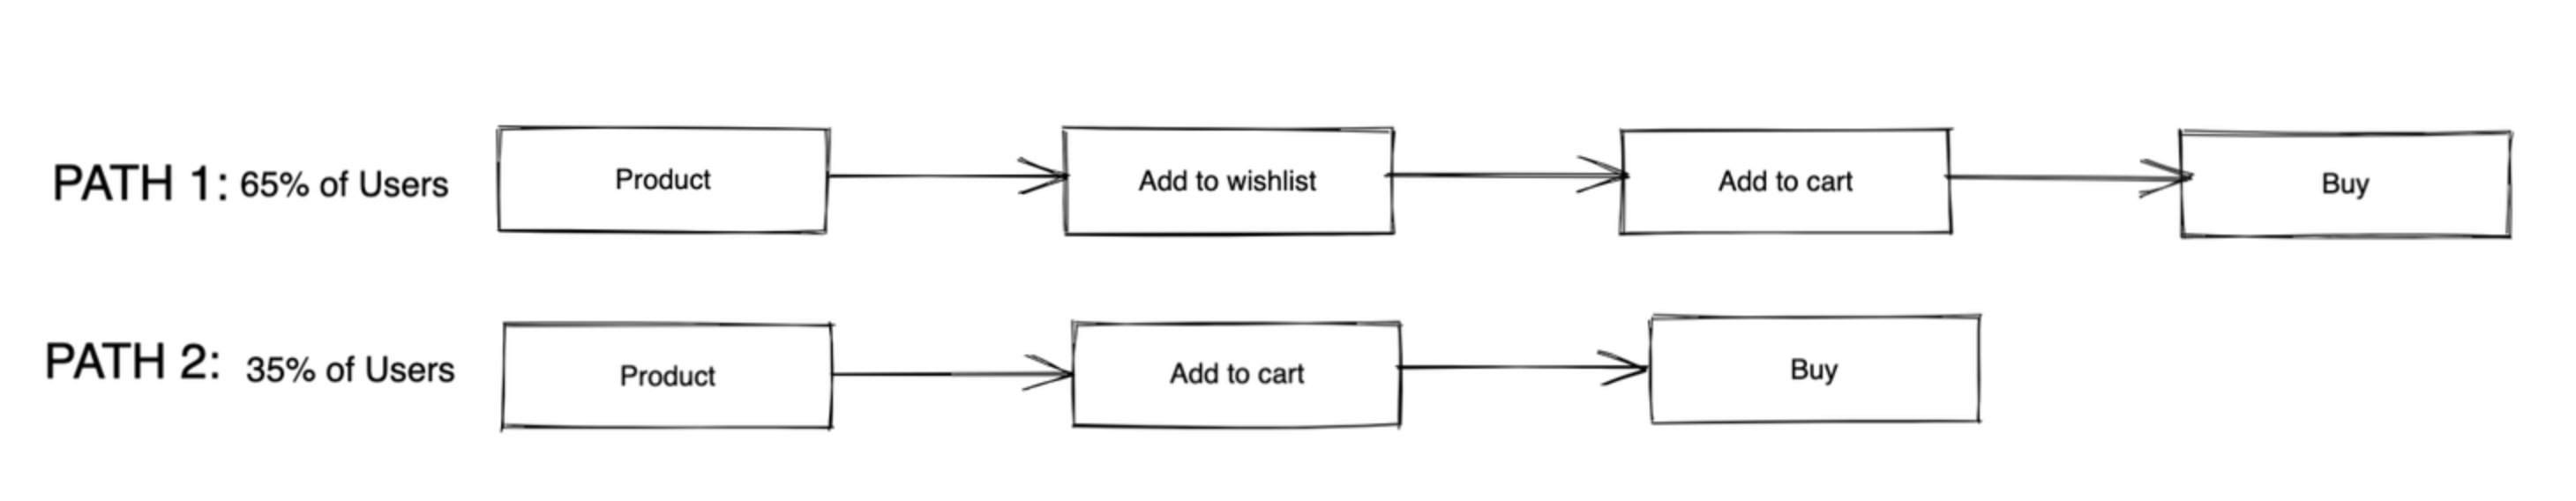

In [22]:
del temp

In [23]:
temp = df.copy()

In [24]:
# Sort the DataFrame by 'DateTime' and filter by maximum 'add_to_cart' date for each user
temp = (temp.sort_values(by='DateTime')
    [(temp.DateTime <= temp.User_id.map(temp[temp['Action'] == 'add_to_cart'].groupby('User_id').DateTime.max()))
    ])

# Print the shape (number of rows and columns) of the resulting DataFrame
print(temp.shape)

# Print the number of unique 'User_id' values in the filtered DataFrame
print(temp.User_id.nunique())

# Display the first 3 rows of the DataFrame
temp.head(3)


(1192, 21)
240


,User_id,Session_id,DateTime,Category,SubCategory,Action,Quantity,Rate,Total Price,Recency,Frequency,Monetary,R,F,M,Group,Score,Loyalty_Level,Date,DayOfWeek,DayOfMonth
942,51725305614,hfg03b-d558-4953-b218,2019-01-01 11:00:00,Men's Fashion,Shirts,search,NaN,NaN,NaN,24.0,2.0,4750.0,4.0,4.0,3.0,443.0,11.0,Platinum,2019-01-01,1,1
943,51725305614,cbvg11b4-fadf-4d3c-8834,2019-01-01 11:05:00,Men's Fashion,Shirts,product_view,NaN,NaN,NaN,24.0,2.0,4750.0,4.0,4.0,3.0,443.0,11.0,Platinum,2019-01-01,1,1
944,51725305614,gcv0ec1-a246-4d24-b94a,2019-01-01 11:10:00,Men's Fashion,Shirts,read_reviews,NaN,NaN,NaN,24.0,2.0,4750.0,4.0,4.0,3.0,443.0,11.0,Platinum,2019-01-01,1,1


In [ ]:
# temp[temp['User_id']==51592642763].sort_values(by='DateTime')

In [25]:
import re

# Define a regular expression pattern to extract the last 3 actions ending with 'add_to_cart'
last_3_actions = r'((?:\S+\s+){0,3}\badd_to_cart)'

# Group the data by 'User_id' and aggregate the 'Action' column as a list
temp_path = temp.sort_values(by='DateTime').groupby('User_id').agg({'Action': lambda x: list(x)}).reset_index()

# Create a new column 'Action_cleaned' by joining the 'Action' list elements with spaces
temp_path['Action_cleaned'] = temp_path['Action'].apply(lambda x: ' '.join(x))

# Extract the last 3 actions ending with 'add_to_cart' using the regular expression
temp_path['Last_3_Actions'] = temp_path['Action_cleaned'].apply(lambda x: re.findall(last_3_actions, x))

# Clean and select the latest path for each user (up to 3 actions)
temp_path['Final_3_Actions'] = temp_path['Last_3_Actions'].apply(lambda x: x[0] if len(x) == 1 else x)
temp_path['Final_3_Actions'] = temp_path['Final_3_Actions'].apply(lambda x: x[1] if len(x) == 2 else x)
temp_path['Final_3_Actions'] = temp_path['Final_3_Actions'].apply(lambda x: x[2] if len(x) == 3 else x)

# Print the shape (number of rows and columns) of the resulting DataFrame
print(temp_path.shape)

# Display the first few rows of the DataFrame
temp_path.head()


(240, 5)


,User_id,Action,Action_cleaned,Last_3_Actions,Final_3_Actions
0,51448162784,"[first_app_open, search, product_view, read_reviews, add_to_cart, search, read_reviews, add_to_cart]",first_app_open search product_view read_reviews add_to_cart search read_reviews add_to_cart,"[search product_view read_reviews add_to_cart, search read_reviews add_to_cart]",search read_reviews add_to_cart
1,51455512201,"[first_app_open, search, product_view, read_reviews, search, product_view, read_reviews, add_to_cart]",first_app_open search product_view read_reviews search product_view read_reviews add_to_cart,[search product_view read_reviews add_to_cart],search product_view read_reviews add_to_cart
2,51462598385,"[search, product_view, read_reviews, add_to_cart, search, product_view, add_to_cart]",search product_view read_reviews add_to_cart search product_view add_to_cart,"[search product_view read_reviews add_to_cart, search product_view add_to_cart]",search product_view add_to_cart
3,51463622150,"[first_app_open, search, read_reviews, search, product_view, add_to_wishlist, checkout, purchase, search, click_wishlist_page, add_to_cart, search, product_view, add_to_cart]",first_app_open search read_reviews search product_view add_to_wishlist checkout purchase search click_wishlist_page add_to_cart search product_view add_to_cart,"[purchase search click_wishlist_page add_to_cart, search product_view add_to_cart]",search product_view add_to_cart
4,51465529647,"[search, add_to_cart, click_wishlist_page, add_to_cart, search, add_to_cart]",search add_to_cart click_wishlist_page add_to_cart search add_to_cart,"[search add_to_cart click_wishlist_page add_to_cart, search add_to_cart]",search add_to_cart


In [26]:
temp_path.Final_3_Actions.value_counts()

product_view read_reviews click_wishlist_page add_to_cart       29
add_to_cart                                                     25
read_reviews click_wishlist_page add_to_cart                    25
click_wishlist_page add_to_cart                                 24
search product_view read_reviews add_to_cart                    21
read_reviews add_to_cart                                        10
product_view read_reviews add_to_cart                           10
read_reviews product_view click_wishlist_page add_to_cart        9
search read_reviews click_wishlist_page add_to_cart              9
search product_view add_to_cart                                  6
search product_view click_wishlist_page add_to_cart              6
product_view click_wishlist_page add_to_cart                     6
search read_reviews add_to_cart                                  5
product_view add_to_cart                                         3
first_app_open search read_reviews add_to_cart                

In [27]:
# Get the top 10 most common paths
top_10_paths = temp_path['Final_3_Actions'].value_counts()[:10].index.to_list()

# Print the top 10 paths
print(top_10_paths)

# Create a new column 'top_paths' to group paths into top 10 or 'others'
temp_path['top_paths'] = temp_path['Final_3_Actions'].apply(lambda x: x if x in top_10_paths else 'others')

# Display the first few rows of the DataFrame with the 'top_paths' column
temp_path.head()


['product_view read_reviews click_wishlist_page add_to_cart', 'add_to_cart', 'read_reviews click_wishlist_page add_to_cart', 'click_wishlist_page add_to_cart', 'search product_view read_reviews add_to_cart', 'read_reviews add_to_cart', 'product_view read_reviews add_to_cart', 'read_reviews product_view click_wishlist_page add_to_cart', 'search read_reviews click_wishlist_page add_to_cart', 'search product_view add_to_cart']


,User_id,Action,Action_cleaned,Last_3_Actions,Final_3_Actions,top_paths
0,51448162784,"[first_app_open, search, product_view, read_reviews, add_to_cart, search, read_reviews, add_to_cart]",first_app_open search product_view read_reviews add_to_cart search read_reviews add_to_cart,"[search product_view read_reviews add_to_cart, search read_reviews add_to_cart]",search read_reviews add_to_cart,others
1,51455512201,"[first_app_open, search, product_view, read_reviews, search, product_view, read_reviews, add_to_cart]",first_app_open search product_view read_reviews search product_view read_reviews add_to_cart,[search product_view read_reviews add_to_cart],search product_view read_reviews add_to_cart,search product_view read_reviews add_to_cart
2,51462598385,"[search, product_view, read_reviews, add_to_cart, search, product_view, add_to_cart]",search product_view read_reviews add_to_cart search product_view add_to_cart,"[search product_view read_reviews add_to_cart, search product_view add_to_cart]",search product_view add_to_cart,search product_view add_to_cart
3,51463622150,"[first_app_open, search, read_reviews, search, product_view, add_to_wishlist, checkout, purchase, search, click_wishlist_page, add_to_cart, search, product_view, add_to_cart]",first_app_open search read_reviews search product_view add_to_wishlist checkout purchase search click_wishlist_page add_to_cart search product_view add_to_cart,"[purchase search click_wishlist_page add_to_cart, search product_view add_to_cart]",search product_view add_to_cart,search product_view add_to_cart
4,51465529647,"[search, add_to_cart, click_wishlist_page, add_to_cart, search, add_to_cart]",search add_to_cart click_wishlist_page add_to_cart search add_to_cart,"[search add_to_cart click_wishlist_page add_to_cart, search add_to_cart]",search add_to_cart,others


In [28]:
temp_path.top_paths.value_counts()

others                                                       72
product_view read_reviews click_wishlist_page add_to_cart    29
read_reviews click_wishlist_page add_to_cart                 25
add_to_cart                                                  25
click_wishlist_page add_to_cart                              24
search product_view read_reviews add_to_cart                 21
product_view read_reviews add_to_cart                        10
read_reviews add_to_cart                                     10
search read_reviews click_wishlist_page add_to_cart           9
read_reviews product_view click_wishlist_page add_to_cart     9
search product_view add_to_cart                               6
Name: top_paths, dtype: int64

In [29]:
gc.collect()

0

### Category/SubCategory level Features:

#### Cart to Purchase ratio (Category/SubCategory):

In [30]:
del temp

In [31]:
temp = df.copy()

In [32]:
temp.head(3)

,User_id,Session_id,DateTime,Category,SubCategory,Action,Quantity,Rate,Total Price,Recency,Frequency,Monetary,R,F,M,Group,Score,Loyalty_Level,Date,DayOfWeek,DayOfMonth
0,52243841613,d76fde-8bb3-4e00-8c23,2019-01-10 10:20:00,Electronic Appliances,Speakers,first_app_open,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-10,3,10
1,52243841613,33dfbd-b87a-4708-9857,2019-01-10 10:22:00,Electronic Appliances,Speakers,search,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-10,3,10
2,57314161118,6511c2-e2e3-422b-b695,2019-01-10 14:00:00,Men's Fashion,Jeans,search,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-10,3,10


In [33]:
# Calculate cart-to-purchase ratio for each category
temp_cart_purch_ratio_category = purchase_ratios(action_col='add_to_cart', id_col='Category', col_name='category_no_of_carts')

# Display the first few rows of the DataFrame
display(temp_cart_purch_ratio_category.head())

# Generate descriptive statistics for the DataFrame
temp_cart_purch_ratio_category.describe()


(89, 2)
(75, 2)
(89, 4)


,Category,category_no_of_carts,no_of_purch,category_no_of_carts_to_purchase_ratio
0,Accessories,15,12.0,0.8
1,Air Conditioner,1,2.0,2.0
2,Appliances,1,1.0,1.0
3,Artwork,1,0.0,0.0
4,Audio,1,0.0,0.0


,category_no_of_carts,no_of_purch,category_no_of_carts_to_purchase_ratio
count,89.000000,89.000000,89.000000
mean,3.146067,2.224719,0.741005
std,3.540514,2.708374,0.564977
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,0.333333
50%,2.000000,1.000000,0.750000
75%,3.000000,3.000000,1.000000
max,16.000000,14.000000,3.000000


In [34]:
# Calculate cart-to-purchase ratio for each subcategory
temp_cart_purch_ratio_subcategory = purchase_ratios(action_col='add_to_cart', id_col='SubCategory', col_name='subcategory_no_of_carts')

# Display the first few rows of the DataFrame
display(temp_cart_purch_ratio_subcategory.head())

# Generate descriptive statistics for the DataFrame
temp_cart_purch_ratio_subcategory.describe()


(239, 2)
(176, 2)
(239, 4)


,SubCategory,subcategory_no_of_carts,no_of_purch,subcategory_no_of_carts_to_purchase_ratio
0,Air Tight Container,1,0.0,0.0
1,Air coolers,1,1.0,1.0
2,Amazon Alexa,1,0.0,0.0
3,Amplifier,1,1.0,1.0
4,Audio Speakers,1,0.0,0.0


,subcategory_no_of_carts,no_of_purch,subcategory_no_of_carts_to_purchase_ratio
count,239.000000,239.000000,239.000000
mean,1.171548,0.769874,0.656555
std,0.654546,0.711086,0.499926
min,1.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000
max,8.000000,4.000000,2.000000


In [35]:
gc.collect()

0

#### Wishlist to Purchase Ratio (Category/SubCategory):

([Contents:](#Contents:))

In [ ]:
del temp

In [ ]:
temp = df.copy()

In [36]:
# Calculate click wishlist to purchase ratio for each category
temp_click_wishlist_purch_ratio_category = purchase_ratios(action_col='click_wishlist_page', id_col='Category', col_name='category_no_of_click_wishlist')

# Print the shape (number of rows and columns) of the resulting DataFrame
print(temp_click_wishlist_purch_ratio_category.shape)

# Display the first few rows of the DataFrame
display(temp_click_wishlist_purch_ratio_category.head())

# Generate descriptive statistics for the DataFrame
temp_click_wishlist_purch_ratio_category.describe()


(72, 2)
(75, 2)
(72, 4)
(72, 4)


,Category,category_no_of_click_wishlist,no_of_purch,category_no_of_click_wishlist_to_purchase_ratio
0,Accessories,14,12.0,0.857143
1,Appliances,3,1.0,0.333333
2,Artwork,1,0.0,0.000000
3,Audio,1,0.0,0.000000
4,Baby Care,4,1.0,0.250000


,category_no_of_click_wishlist,no_of_purch,category_no_of_click_wishlist_to_purchase_ratio
count,72.000000,72.000000,72.000000
mean,2.805556,2.430556,0.913683
std,2.548896,2.963755,0.858968
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,0.250000
50%,2.000000,1.000000,0.791667
75%,4.000000,3.000000,1.500000
max,14.000000,14.000000,4.000000


In [37]:
# Calculate click wishlist to purchase ratio for each subcategory
temp_click_wishlist_purch_ratio_subcategory = purchase_ratios(action_col='click_wishlist_page', id_col='SubCategory', col_name='subcategory_no_of_click_wishlist')

# Print the shape (number of rows and columns) of the resulting DataFrame
print(temp_click_wishlist_purch_ratio_subcategory.shape)

# Display the first few rows of the DataFrame
display(temp_click_wishlist_purch_ratio_subcategory.head())

# Generate descriptive statistics for the DataFrame
temp_click_wishlist_purch_ratio_subcategory.describe()


(175, 2)
(176, 2)
(175, 4)
(175, 4)


,SubCategory,subcategory_no_of_click_wishlist,no_of_purch,subcategory_no_of_click_wishlist_to_purchase_ratio
0,Air Tight Container,1,0.0,0.0
1,Air coolers,1,1.0,1.0
2,Amazon Alexa,1,0.0,0.0
3,Audio Speakers,1,0.0,0.0
4,Baby Shampoo,1,0.0,0.0


,subcategory_no_of_click_wishlist,no_of_purch,subcategory_no_of_click_wishlist_to_purchase_ratio
count,175.000000,175.000000,175.000000
mean,1.154286,0.520000,0.450000
std,0.581488,0.725876,0.595253
min,1.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000
max,6.000000,4.000000,4.000000


In [38]:
# Calculate add wishlist to purchase ratio for each category
temp_add_wishlist_purch_ratio_category = purchase_ratios(action_col='add_to_wishlist', id_col='Category', col_name='category_no_of_add_wishlist')

# Print the shape (number of rows and columns) of the resulting DataFrame
print(temp_add_wishlist_purch_ratio_category.shape)

# Display the first few rows of the DataFrame
display(temp_add_wishlist_purch_ratio_category.head())

# Generate descriptive statistics for the DataFrame
temp_add_wishlist_purch_ratio_category.describe()


(18, 2)
(75, 2)
(18, 4)
(18, 4)


,Category,category_no_of_add_wishlist,no_of_purch,category_no_of_add_wishlist_to_purchase_ratio
0,Accessories,3,12,4.0
1,Baby Care,1,1,1.0
2,Bed room,1,5,5.0
3,Digital Appliances,1,2,2.0
4,Digital Devices,5,7,1.4


,category_no_of_add_wishlist,no_of_purch,category_no_of_add_wishlist_to_purchase_ratio
count,18.000000,18.000000,18.000000
mean,2.111111,5.333333,2.901852
std,1.529663,4.130233,2.395843
min,1.000000,1.000000,1.000000
25%,1.000000,2.000000,1.000000
50%,1.500000,4.000000,2.166667
75%,2.750000,8.750000,3.750000
max,6.000000,14.000000,9.000000


In [39]:
# Calculate add wishlist to purchase ratio for each subcategory
temp_add_wishlist_purch_ratio_subcategory = purchase_ratios(action_col='add_to_wishlist', id_col='SubCategory', col_name='subcategory_no_of_add_wishlist')

# Print the shape (number of rows and columns) of the resulting DataFrame
print(temp_add_wishlist_purch_ratio_subcategory.shape)

# Display the first few rows of the DataFrame
display(temp_add_wishlist_purch_ratio_subcategory.head())

# Generate descriptive statistics for the DataFrame
temp_add_wishlist_purch_ratio_subcategory.describe()


(26, 2)
(176, 2)
(26, 4)
(26, 4)


,SubCategory,subcategory_no_of_add_wishlist,no_of_purch,subcategory_no_of_add_wishlist_to_purchase_ratio
0,Books,2,4,2.000000
1,Bp monitors,1,1,1.000000
2,Bumpers,1,1,1.000000
3,Cases,3,2,0.666667
4,Charging wire,1,3,3.000000


,subcategory_no_of_add_wishlist,no_of_purch,subcategory_no_of_add_wishlist_to_purchase_ratio
count,26.000000,26.000000,26.000000
mean,1.461538,1.538462,1.185897
std,0.706018,1.066987,0.872196
min,1.000000,1.000000,0.333333
25%,1.000000,1.000000,0.750000
50%,1.000000,1.000000,1.000000
75%,2.000000,1.000000,1.000000
max,3.000000,4.000000,4.000000


In [40]:
gc.collect()

0

#### Product View to Purchase ratio (Category/SubCategory):

In [41]:
del temp

In [42]:
temp = df.copy()

In [43]:
# Calculate product view wishlist to purchase ratio for each category
temp_product_view_purch_ratio_category = purchase_ratios(action_col='product_view', id_col='Category', col_name='category_no_of_product_view')

# Print the shape (number of rows and columns) of the resulting DataFrame
print(temp_product_view_purch_ratio_category.shape)

# Display the first few rows of the DataFrame
display(temp_product_view_purch_ratio_category.head())

# Generate descriptive statistics for the DataFrame
temp_product_view_purch_ratio_category.describe()


(90, 2)
(75, 2)
(90, 4)
(90, 4)


,Category,category_no_of_product_view,no_of_purch,category_no_of_product_view_to_purchase_ratio
0,Accessories,9,12.0,1.333333
1,Air Conditioner,7,2.0,0.285714
2,Artwork,1,0.0,0.000000
3,Audio,1,0.0,0.000000
4,Baby Care,3,1.0,0.333333


,category_no_of_product_view,no_of_purch,category_no_of_product_view_to_purchase_ratio
count,90.000000,90.000000,90.000000
mean,3.244444,2.077778,0.607009
std,3.468352,2.769123,0.634233
min,1.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000
50%,2.000000,1.000000,0.500000
75%,4.000000,2.750000,1.000000
max,26.000000,14.000000,3.000000


In [44]:
# Calculate product view wishlist to purchase ratio for each subcategory
temp_product_view_purch_ratio_subcategory = purchase_ratios(action_col='product_view', id_col='SubCategory', col_name='subcategory_no_of_product_view')

# Print the shape (number of rows and columns) of the resulting DataFrame
print(temp_product_view_purch_ratio_subcategory.shape)

# Display the first few rows of the DataFrame
display(temp_product_view_purch_ratio_subcategory.head())

# Generate descriptive statistics for the DataFrame
temp_product_view_purch_ratio_subcategory.describe()


(216, 2)
(176, 2)
(216, 4)
(216, 4)


,SubCategory,subcategory_no_of_product_view,no_of_purch,subcategory_no_of_product_view_to_purchase_ratio
0,Amazon Alexa,1,0.0,0.000000
1,Arm sleeve,1,0.0,0.000000
2,Aux Cable,3,1.0,0.333333
3,Baby Shampoo,1,0.0,0.000000
4,Baby Shower gel,1,0.0,0.000000


,subcategory_no_of_product_view,no_of_purch,subcategory_no_of_product_view_to_purchase_ratio
count,216.000000,216.000000,216.000000
mean,1.351852,0.495370,0.319422
std,0.860663,0.753273,0.431870
min,1.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000
75%,1.000000,1.000000,0.666667
max,7.000000,4.000000,1.500000


---

## Modeling Dataset Creation:

In [45]:
print(df.shape)
df.head()

(2090, 21)


,User_id,Session_id,DateTime,Category,SubCategory,Action,Quantity,Rate,Total Price,Recency,Frequency,Monetary,R,F,M,Group,Score,Loyalty_Level,Date,DayOfWeek,DayOfMonth
0,52243841613,d76fde-8bb3-4e00-8c23,2019-01-10 10:20:00,Electronic Appliances,Speakers,first_app_open,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-10,3,10
1,52243841613,33dfbd-b87a-4708-9857,2019-01-10 10:22:00,Electronic Appliances,Speakers,search,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-10,3,10
2,57314161118,6511c2-e2e3-422b-b695,2019-01-10 14:00:00,Men's Fashion,Jeans,search,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-10,3,10
3,57314161118,90fc70-0e80-4590-96f3,2019-01-10 14:07:00,Men's Fashion,Jeans,product_view,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-10,3,10
4,57314161118,bd7419-2748-4c56-95b4,2019-01-10 14:12:00,Men's Fashion,Jeans,read_reviews,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-10,3,10


In [46]:
# Define the target group as those who added items to the cart (Trigger point)
df_base = (df[df['Action'] == 'add_to_cart']
              .groupby('User_id')
              .agg({'Category': 'max', 'SubCategory': 'max'})
              .reset_index()
           )

# Print the shape (number of rows and columns) of the resulting DataFrame
print(df_base.shape)

# Display the first few rows of the DataFrame
df_base.head()


(240, 3)


,User_id,Category,SubCategory
0,51448162784,Camera Accessories,Camera Lens
1,51455512201,Men's Fashion,Shoes
2,51462598385,Mobile & Accessories,USB Cord
3,51463622150,Stationary,Paints
4,51465529647,Home Decor,Wall hangings


In [47]:
# Merge the 'df_base' DataFrame with the 'temp_days_active' DataFrame on the 'User_id' column
df_base = pd.merge(df_base, temp_days_active, on='User_id', how='left')

# Print the shape (number of rows and columns) of the resulting DataFrame
print(df_base.shape)

# Display the first 3 rows of the merged DataFrame
df_base.head(3)


(240, 4)


,User_id,Category,SubCategory,no_of_days_active
0,51448162784,Camera Accessories,Camera Lens,3
1,51455512201,Men's Fashion,Shoes,3
2,51462598385,Mobile & Accessories,USB Cord,5


In [48]:
# Calculate RFM features at the user level and aggregate them
temp_rfm_feats = df.groupby('User_id').agg({'R': 'max', 'F': 'max', 'M': 'max', 'Loyalty_Level': 'max'}).reset_index()

# Merge the 'df_base' DataFrame with the 'temp_rfm_feats' DataFrame on the 'User_id' column
df_base = pd.merge(df_base, temp_rfm_feats, on='User_id', how='left')

# Print the shape (number of rows and columns) of the resulting DataFrame
print(df_base.shape)

# Display the first 3 rows of the merged DataFrame
df_base.head(3)


(240, 8)


,User_id,Category,SubCategory,no_of_days_active,R,F,M,Loyalty_Level
0,51448162784,Camera Accessories,Camera Lens,3,4.0,4.0,4.0,Platinum
1,51455512201,Men's Fashion,Shoes,3,3.0,1.0,3.0,Gold
2,51462598385,Mobile & Accessories,USB Cord,5,4.0,4.0,1.0,Platinum


In [49]:
# Merge the 'df_base' DataFrame with the 'temp_user_purchase_date' DataFrame containing 'avg_time_between_purchase'
df_base = pd.merge(df_base, temp_user_purchase_date[['User_id', 'avg_time_between_purchase']], 
                   on='User_id', how='left')

# Print the shape (number of rows and columns) of the resulting DataFrame
print(df_base.shape)

# Display the first 3 rows of the merged DataFrame
df_base.head(3)


(240, 9)


,User_id,Category,SubCategory,no_of_days_active,R,F,M,Loyalty_Level,avg_time_between_purchase
0,51448162784,Camera Accessories,Camera Lens,3,4.0,4.0,4.0,Platinum,184.0
1,51455512201,Men's Fashion,Shoes,3,3.0,1.0,3.0,Gold,NaN
2,51462598385,Mobile & Accessories,USB Cord,5,4.0,4.0,1.0,Platinum,56.0


In [50]:
# Merge the 'df_base' DataFrame with the 'temp_cart_purch_ratio_user' DataFrame containing 'no_of_carts_to_purchase_ratio'
df_base = pd.merge(df_base, temp_cart_purch_ratio_user[['User_id', 'no_of_carts_to_purchase_ratio']], 
                   on='User_id', how='left')

# Print the shape (number of rows and columns) of the resulting DataFrame
print(df_base.shape)

# Display the first 3 rows of the merged DataFrame
df_base.head(3)


(240, 10)


,User_id,Category,SubCategory,no_of_days_active,R,F,M,Loyalty_Level,avg_time_between_purchase,no_of_carts_to_purchase_ratio
0,51448162784,Camera Accessories,Camera Lens,3,4.0,4.0,4.0,Platinum,184.0,1.0
1,51455512201,Men's Fashion,Shoes,3,3.0,1.0,3.0,Gold,NaN,1.0
2,51462598385,Mobile & Accessories,USB Cord,5,4.0,4.0,1.0,Platinum,56.0,1.0


In [51]:
# Merge the 'df_base' DataFrame with the 'temp_click_wishlist_purch_ratio_user' DataFrame containing 'no_of_click_wishlist_to_purchase_ratio'
df_base = pd.merge(df_base, 
                   temp_click_wishlist_purch_ratio_user[['User_id','no_of_click_wishlist_to_purchase_ratio']], 
                   on='User_id', how='left')

# Print the shape (number of rows and columns) of the resulting DataFrame
print(df_base.shape)

# Merge the 'df_base' DataFrame with the 'temp_add_wishlist_purch_ratio_user' DataFrame containing 'no_of_add_wishlist_to_purchase_ratio'
df_base = pd.merge(df_base, 
                   temp_add_wishlist_purch_ratio_user[['User_id','no_of_add_wishlist_to_purchase_ratio']], 
                   on='User_id', how='left')

# Print the shape (number of rows and columns) of the resulting DataFrame
print(df_base.shape)

# Display the first 3 rows of the merged DataFrame
df_base.head(3)


(240, 11)
(240, 12)


,User_id,Category,SubCategory,no_of_days_active,R,F,M,Loyalty_Level,avg_time_between_purchase,no_of_carts_to_purchase_ratio,no_of_click_wishlist_to_purchase_ratio,no_of_add_wishlist_to_purchase_ratio
0,51448162784,Camera Accessories,Camera Lens,3,4.0,4.0,4.0,Platinum,184.0,1.0,2.0,NaN
1,51455512201,Men's Fashion,Shoes,3,3.0,1.0,3.0,Gold,NaN,1.0,NaN,NaN
2,51462598385,Mobile & Accessories,USB Cord,5,4.0,4.0,1.0,Platinum,56.0,1.0,NaN,NaN


In [52]:
# Merge the 'df_base' DataFrame with the 'temp_path' DataFrame containing 'top_paths'
df_base = pd.merge(df_base, temp_path[['User_id', 'top_paths'], 
                   on='User_id', how='left')

# Print the shape (number of rows and columns) of the resulting DataFrame
print(df_base.shape)

# Display the first 3 rows of the merged DataFrame
df_base.head(3)


(240, 13)


,User_id,Category,SubCategory,no_of_days_active,R,F,M,Loyalty_Level,avg_time_between_purchase,no_of_carts_to_purchase_ratio,no_of_click_wishlist_to_purchase_ratio,no_of_add_wishlist_to_purchase_ratio,top_paths
0,51448162784,Camera Accessories,Camera Lens,3,4.0,4.0,4.0,Platinum,184.0,1.0,2.0,NaN,others
1,51455512201,Men's Fashion,Shoes,3,3.0,1.0,3.0,Gold,NaN,1.0,NaN,NaN,search product_view read_reviews add_to_cart
2,51462598385,Mobile & Accessories,USB Cord,5,4.0,4.0,1.0,Platinum,56.0,1.0,NaN,NaN,search product_view add_to_cart


In [53]:
# Merge the 'df_base' DataFrame with the 'temp_cart_purch_ratio_category' DataFrame containing 'category_no_of_carts_to_purchase_ratio' based on the 'Category' column
df_base = pd.merge(df_base, temp_cart_purch_ratio_category[['Category', 'category_no_of_carts_to_purchase_ratio']], 
                   on='Category', how='left')

# Merge the 'df_base' DataFrame with the 'temp_cart_purch_ratio_subcategory' DataFrame containing 'subcategory_no_of_carts_to_purchase_ratio' based on the 'SubCategory' column
df_base = pd.merge(df_base, temp_cart_purch_ratio_subcategory[['SubCategory', 'subcategory_no_of_carts_to_purchase_ratio']], 
                   on='SubCategory', how='left')

# Print the shape (number of rows and columns) of the resulting DataFrame
print(df_base.shape)

# Display the first 3 rows of the merged DataFrame
df_base.head(3)


(240, 15)


,User_id,Category,SubCategory,no_of_days_active,R,F,M,Loyalty_Level,avg_time_between_purchase,no_of_carts_to_purchase_ratio,no_of_click_wishlist_to_purchase_ratio,no_of_add_wishlist_to_purchase_ratio,top_paths,category_no_of_carts_to_purchase_ratio,subcategory_no_of_carts_to_purchase_ratio
0,51448162784,Camera Accessories,Camera Lens,3,4.0,4.0,4.0,Platinum,184.0,1.0,2.0,NaN,others,0.300000,1.0
1,51455512201,Men's Fashion,Shoes,3,3.0,1.0,3.0,Gold,NaN,1.0,NaN,NaN,search product_view read_reviews add_to_cart,0.800000,1.0
2,51462598385,Mobile & Accessories,USB Cord,5,4.0,4.0,1.0,Platinum,56.0,1.0,NaN,NaN,search product_view add_to_cart,0.933333,1.0


In [54]:
# Merge the 'df_base' DataFrame with the 'temp_click_wishlist_purch_ratio_category' DataFrame containing 'category_no_of_click_wishlist_to_purchase_ratio' based on the 'Category' column
df_base = pd.merge(df_base, 
                   temp_click_wishlist_purch_ratio_category[['Category', 'category_no_of_click_wishlist_to_purchase_ratio']], 
                   on='Category', how='left')

# Merge the 'df_base' DataFrame with the 'temp_click_wishlist_purch_ratio_subcategory' DataFrame containing 'subcategory_no_of_click_wishlist_to_purchase_ratio' based on the 'SubCategory' column
df_base = pd.merge(df_base,
                   temp_click_wishlist_purch_ratio_subcategory[['SubCategory', 'subcategory_no_of_click_wishlist_to_purchase_ratio']], 
                   on='SubCategory', how='left')

# Merge the 'df_base' DataFrame with the 'temp_add_wishlist_purch_ratio_category' DataFrame containing 'category_no_of_add_wishlist_to_purchase_ratio' based on the 'Category' column
df_base = pd.merge(df_base, 
                   temp_add_wishlist_purch_ratio_category[['Category', 'category_no_of_add_wishlist_to_purchase_ratio']], 
                   on='Category', how='left')

# Merge the 'df_base' DataFrame with the 'temp_add_wishlist_purch_ratio_subcategory' DataFrame containing 'subcategory_no_of_add_wishlist_to_purchase_ratio' based on the 'SubCategory' column
df_base = pd.merge(df_base,
                   temp_add_wishlist_purch_ratio_subcategory[['SubCategory', 'subcategory_no_of_add_wishlist_to_purchase_ratio']], 
                   on='SubCategory', how='left')

# Print the shape (number of rows and columns) of the resulting DataFrame
print(df_base.shape)

# Display the first 3 rows of the merged DataFrame
df_base.head(3)


(240, 19)


,User_id,Category,SubCategory,no_of_days_active,R,F,M,Loyalty_Level,avg_time_between_purchase,no_of_carts_to_purchase_ratio,no_of_click_wishlist_to_purchase_ratio,no_of_add_wishlist_to_purchase_ratio,top_paths,category_no_of_carts_to_purchase_ratio,subcategory_no_of_carts_to_purchase_ratio,category_no_of_click_wishlist_to_purchase_ratio,subcategory_no_of_click_wishlist_to_purchase_ratio,category_no_of_add_wishlist_to_purchase_ratio,subcategory_no_of_add_wishlist_to_purchase_ratio
0,51448162784,Camera Accessories,Camera Lens,3,4.0,4.0,4.0,Platinum,184.0,1.0,2.0,NaN,others,0.300000,1.0,0.30,NaN,NaN,NaN
1,51455512201,Men's Fashion,Shoes,3,3.0,1.0,3.0,Gold,NaN,1.0,NaN,NaN,search product_view read_reviews add_to_cart,0.800000,1.0,2.00,1.0,8.000000,NaN
2,51462598385,Mobile & Accessories,USB Cord,5,4.0,4.0,1.0,Platinum,56.0,1.0,NaN,NaN,search product_view add_to_cart,0.933333,1.0,1.75,NaN,2.333333,NaN


In [55]:
# Merge the 'df_base' DataFrame with the 'temp_product_view_purch_ratio_category' DataFrame containing 'category_no_of_product_view_to_purchase_ratio' based on the 'Category' column
df_base = pd.merge(df_base, 
                   temp_product_view_purch_ratio_category[['Category', 'category_no_of_product_view_to_purchase_ratio']], 
                   on='Category', how='left')

# Merge the 'df_base' DataFrame with the 'temp_product_view_purch_ratio_subcategory' DataFrame containing 'subcategory_no_of_product_view_to_purchase_ratio' based on the 'SubCategory' column
df_base = pd.merge(df_base,
                   temp_product_view_purch_ratio_subcategory[['SubCategory', 'subcategory_no_of_product_view_to_purchase_ratio']], 
                   on='SubCategory', how='left')

# Print the shape (number of rows and columns) of the resulting DataFrame
print(df_base.shape)

# Display the first 3 rows of the merged DataFrame
df_base.head(3)


(240, 21)


,User_id,Category,SubCategory,no_of_days_active,R,F,M,Loyalty_Level,avg_time_between_purchase,no_of_carts_to_purchase_ratio,no_of_click_wishlist_to_purchase_ratio,no_of_add_wishlist_to_purchase_ratio,top_paths,category_no_of_carts_to_purchase_ratio,subcategory_no_of_carts_to_purchase_ratio,category_no_of_click_wishlist_to_purchase_ratio,subcategory_no_of_click_wishlist_to_purchase_ratio,category_no_of_add_wishlist_to_purchase_ratio,subcategory_no_of_add_wishlist_to_purchase_ratio,category_no_of_product_view_to_purchase_ratio,subcategory_no_of_product_view_to_purchase_ratio
0,51448162784,Camera Accessories,Camera Lens,3,4.0,4.0,4.0,Platinum,184.0,1.0,2.0,NaN,others,0.300000,1.0,0.30,NaN,NaN,NaN,0.600000,1.0
1,51455512201,Men's Fashion,Shoes,3,3.0,1.0,3.0,Gold,NaN,1.0,NaN,NaN,search product_view read_reviews add_to_cart,0.800000,1.0,2.00,1.0,8.000000,NaN,0.615385,0.5
2,51462598385,Mobile & Accessories,USB Cord,5,4.0,4.0,1.0,Platinum,56.0,1.0,NaN,NaN,search product_view add_to_cart,0.933333,1.0,1.75,NaN,2.333333,NaN,0.538462,1.0


In [62]:
# Drop the 'Target' column if already created
# df_base = df_base.drop('Target', axis=1)

# Filter the 'temp' DataFrame by selecting rows where the 'DateTime' matches the maximum purchase date for each user
temp = (df.sort_values(by='DateTime')
        [(df.DateTime == df.User_id.map(df[df['Action']=='purchase'].groupby('User_id').DateTime.max()))]
       )

# Print the shape (number of rows and columns) of the filtered 'temp' DataFrame
print(temp.shape)

# Calculate the number of purchase actions for each user
purchase_users = temp[temp['Action']=='purchase'].groupby('User_id')['Action'].count().reset_index()

# Display the first 5 rows of the 'purchase_users' DataFrame
display(purchase_users.head(5))

# Merge the 'df_base' DataFrame with the 'purchase_users' DataFrame on the 'User_id' column
df_base = pd.merge(df_base, purchase_users, on='User_id', how='left')

# Fill NaN values in the 'Action' column with 0 and rename it to 'Target'
df_base['Action'] = df_base['Action'].fillna(0)
df_base.rename(columns={'Action': 'Target'}, inplace=True)

# Print the shape (number of rows and columns) of the resulting DataFrame
print(df_base.shape)

# Display the value counts of the 'Target' column in 'df_base'
print(df_base.Target.value_counts())

# Display the first 3 rows of the merged DataFrame
df_base.head(3)


(179, 21)


,User_id,Action
0,51448162784,1
1,51455512201,1
2,51462598385,1
3,51463622150,1
4,51465529647,1


(240, 22)
1.0    147
0.0     93
Name: Target, dtype: int64


,User_id,Category,SubCategory,no_of_days_active,R,F,M,Loyalty_Level,avg_time_between_purchase,no_of_carts_to_purchase_ratio,no_of_click_wishlist_to_purchase_ratio,no_of_add_wishlist_to_purchase_ratio,top_paths,category_no_of_carts_to_purchase_ratio,subcategory_no_of_carts_to_purchase_ratio,category_no_of_click_wishlist_to_purchase_ratio,subcategory_no_of_click_wishlist_to_purchase_ratio,category_no_of_add_wishlist_to_purchase_ratio,subcategory_no_of_add_wishlist_to_purchase_ratio,category_no_of_product_view_to_purchase_ratio,subcategory_no_of_product_view_to_purchase_ratio,Target
0,51448162784,Camera Accessories,Camera Lens,3,4.0,4.0,4.0,Platinum,184.0,1.0,2.0,NaN,others,0.300000,1.0,0.30,NaN,NaN,NaN,0.600000,1.0,1.0
1,51455512201,Men's Fashion,Shoes,3,3.0,1.0,3.0,Gold,NaN,1.0,NaN,NaN,search product_view read_reviews add_to_cart,0.800000,1.0,2.00,1.0,8.000000,NaN,0.615385,0.5,1.0
2,51462598385,Mobile & Accessories,USB Cord,5,4.0,4.0,1.0,Platinum,56.0,1.0,NaN,NaN,search product_view add_to_cart,0.933333,1.0,1.75,NaN,2.333333,NaN,0.538462,1.0,1.0


In [63]:
df_base.isna().sum()

User_id                                                 0
Category                                                0
SubCategory                                             0
no_of_days_active                                       0
R                                                      93
F                                                      93
M                                                      93
Loyalty_Level                                          93
avg_time_between_purchase                             208
no_of_carts_to_purchase_ratio                           0
no_of_click_wishlist_to_purchase_ratio                 99
no_of_add_wishlist_to_purchase_ratio                  217
top_paths                                               0
category_no_of_carts_to_purchase_ratio                  0
subcategory_no_of_carts_to_purchase_ratio               0
category_no_of_click_wishlist_to_purchase_ratio        25
subcategory_no_of_click_wishlist_to_purchase_ratio    100
category_no_of

Imputation Strategy:

* R, F, M --> Zero imputation (because RFM score of 0 means the user is a new user)
* avg_time_between_purchae --> -1 imputation (since most users in the data is first time this feature has more NaN values)
* Rest all features --> zero imputation

In [64]:
# Impute null values in the 'avg_time_between_purchase' column with -1
df_base['avg_time_between_purchase'] = df_base['avg_time_between_purchase'].fillna(-1)

# Fill all remaining null values with 0
df_base = df_base.fillna(0)

# Check for and print the number of null values in the DataFrame
df_base.isna().sum()


User_id                                               0
Category                                              0
SubCategory                                           0
no_of_days_active                                     0
R                                                     0
F                                                     0
M                                                     0
Loyalty_Level                                         0
avg_time_between_purchase                             0
no_of_carts_to_purchase_ratio                         0
no_of_click_wishlist_to_purchase_ratio                0
no_of_add_wishlist_to_purchase_ratio                  0
top_paths                                             0
category_no_of_carts_to_purchase_ratio                0
subcategory_no_of_carts_to_purchase_ratio             0
category_no_of_click_wishlist_to_purchase_ratio       0
subcategory_no_of_click_wishlist_to_purchase_ratio    0
category_no_of_add_wishlist_to_purchase_ratio   

---

## Model Building:

In [65]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [66]:
# Create a new DataFrame 'df_model' as a copy of 'df_base'
df_model = df_base.copy()

# Print the shape (number of rows and columns) of the 'df_model' DataFrame
print(df_model.shape)

# Display the first 3 rows of the copied DataFrame
df_model.head(3)


(240, 22)


,User_id,Category,SubCategory,no_of_days_active,R,F,M,Loyalty_Level,avg_time_between_purchase,no_of_carts_to_purchase_ratio,no_of_click_wishlist_to_purchase_ratio,no_of_add_wishlist_to_purchase_ratio,top_paths,category_no_of_carts_to_purchase_ratio,subcategory_no_of_carts_to_purchase_ratio,category_no_of_click_wishlist_to_purchase_ratio,subcategory_no_of_click_wishlist_to_purchase_ratio,category_no_of_add_wishlist_to_purchase_ratio,subcategory_no_of_add_wishlist_to_purchase_ratio,category_no_of_product_view_to_purchase_ratio,subcategory_no_of_product_view_to_purchase_ratio,Target
0,51448162784,Camera Accessories,Camera Lens,3,4.0,4.0,4.0,Platinum,184.0,1.0,2.0,0.0,others,0.300000,1.0,0.30,0.0,0.000000,0.0,0.600000,1.0,1.0
1,51455512201,Men's Fashion,Shoes,3,3.0,1.0,3.0,Gold,-1.0,1.0,0.0,0.0,search product_view read_reviews add_to_cart,0.800000,1.0,2.00,1.0,8.000000,0.0,0.615385,0.5,1.0
2,51462598385,Mobile & Accessories,USB Cord,5,4.0,4.0,1.0,Platinum,56.0,1.0,0.0,0.0,search product_view add_to_cart,0.933333,1.0,1.75,0.0,2.333333,0.0,0.538462,1.0,1.0


In [67]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 22 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   User_id                                             240 non-null    int64  
 1   Category                                            240 non-null    object 
 2   SubCategory                                         240 non-null    object 
 3   no_of_days_active                                   240 non-null    int64  
 4   R                                                   240 non-null    float64
 5   F                                                   240 non-null    float64
 6   M                                                   240 non-null    float64
 7   Loyalty_Level                                       240 non-null    object 
 8   avg_time_between_purchase                           240 non-null    float64
 9  

In [68]:
# Define the list of categorical columns (only 'top_paths' in this case)
cat_cols = ['top_paths']

# Define the list of numeric columns
num_cols = df_model.drop(['Target', 'User_id'], axis=1).select_dtypes(['int', 'float']).columns.tolist()

# Create a DataFrame 'cat_df' containing one-hot encoded categorical columns
cat_df = df_model[cat_cols]
cat_df = pd.get_dummies(cat_df)

# Initialize a MinMaxScaler
scaler = MinMaxScaler()

# Scale the numeric columns in 'df_model' using the scaler
num_df = scaler.fit_transform(df_model[num_cols])
num_df = pd.DataFrame(num_df, columns=num_cols)

# Concatenate the scaled numeric columns, one-hot encoded categorical columns, and 'Target' column to create 'final_df'
final_df = pd.concat([num_df, cat_df, df_model[['Target']], axis=1)

# Print the shape (number of rows and columns) of 'final_df'
print(final_df.shape)

# Display the first 3 rows of 'final_df'
final_df.head(3)


(240, 28)


,no_of_days_active,R,F,M,avg_time_between_purchase,no_of_carts_to_purchase_ratio,no_of_click_wishlist_to_purchase_ratio,no_of_add_wishlist_to_purchase_ratio,category_no_of_carts_to_purchase_ratio,subcategory_no_of_carts_to_purchase_ratio,category_no_of_click_wishlist_to_purchase_ratio,subcategory_no_of_click_wishlist_to_purchase_ratio,category_no_of_add_wishlist_to_purchase_ratio,subcategory_no_of_add_wishlist_to_purchase_ratio,category_no_of_product_view_to_purchase_ratio,subcategory_no_of_product_view_to_purchase_ratio,top_paths_add_to_cart,top_paths_click_wishlist_page add_to_cart,top_paths_others,top_paths_product_view read_reviews add_to_cart,top_paths_product_view read_reviews click_wishlist_page add_to_cart,top_paths_read_reviews add_to_cart,top_paths_read_reviews click_wishlist_page add_to_cart,top_paths_read_reviews product_view click_wishlist_page add_to_cart,top_paths_search product_view add_to_cart,top_paths_search product_view read_reviews add_to_cart,top_paths_search read_reviews click_wishlist_page add_to_cart,Target
0,0.285714,1.00,1.00,1.00,0.748988,0.333333,1.0,0.0,0.100000,0.5,0.0750,0.00,0.000000,0.0,0.200000,0.666667,0,0,1,0,0,0,0,0,0,0,0,1.0
1,0.285714,0.75,0.25,0.75,0.000000,0.333333,0.0,0.0,0.266667,0.5,0.5000,0.25,0.888889,0.0,0.205128,0.333333,0,0,0,0,0,0,0,0,0,1,0,1.0
2,0.571429,1.00,1.00,0.25,0.230769,0.333333,0.0,0.0,0.311111,0.5,0.4375,0.00,0.259259,0.0,0.179487,0.666667,0,0,0,0,0,0,0,0,1,0,0,1.0


In [69]:
# Split the 'final_df' DataFrame into features (X) and the target variable (Y)
X = final_df.drop(['Target'], axis=1)
Y = final_df[['Target']]

# Perform the train-test split with a test size of 30%
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

# Print the shapes (number of rows and columns) of the train and test sets for both features and the target
print((x_train.shape, y_train.shape), (x_test.shape, y_test.shape))


((168, 27), (168, 1)) ((72, 27), (72, 1))


In [71]:
# Print the counts of each unique value in the training set's target variable
print(y_train.value_counts())

# Print the normalized counts (proportions) of each unique value in the training set's target variable
print(y_train.value_counts(normalize=True))


Target
1.0       106
0.0        62
dtype: int64
Target
1.0       0.630952
0.0       0.369048
dtype: float64


In [72]:
# Create a logistic regression model with balanced class weights and a random seed of 123
logreg = LogisticRegression(class_weight='balanced', random_state=123)

# Fit the logistic regression model using the training data
logreg.fit(x_train, y_train)


LogisticRegression(class_weight='balanced', random_state=123)

In [73]:
# Predict probabilities for the positive class on the test data
preds = logreg.predict_proba(x_test)[:,1]

# Print the predicted probabilities
print(preds)

# Calculate and print the ROC-AUC score by comparing the predicted probabilities to the actual target values
print("Test ROC-AUC:" + str(metrics.roc_auc_score(y_test, preds)))


[0.85737606 0.93957738 0.1104671  0.06444445 0.99767414 0.06763725
 0.85338434 0.99396238 0.9496709  0.97345436 0.04572647 0.94750661
 0.04934947 0.04384109 0.08896566 0.97823581 0.93520536 0.07477872
 0.06327506 0.98724583 0.06535566 0.09149613 0.74625915 0.04532475
 0.9391395  0.89547272 0.08315233 0.95091977 0.98587321 0.99690217
 0.07131343 0.7501544  0.99956191 0.1104671  0.98565941 0.96051529
 0.12110078 0.04629584 0.08353235 0.06830167 0.93280085 0.93273583
 0.80229383 0.06475065 0.99851725 0.10137371 0.76120191 0.07260432
 0.98998973 0.06931089 0.05007252 0.95027881 0.98279259 0.05617873
 0.9954749  0.06327506 0.95392076 0.09467901 0.06931089 0.98705358
 0.94349188 0.98986352 0.98751659 0.03722258 0.04182871 0.98598568
 0.94099425 0.06931089 0.93373929 0.99463163 0.95115176 0.87144627]
Test ROC-AUC:1.0


In [74]:
# Predict labels (0 or 1) on the test data
preds_label = logreg.predict(x_test)

# Print the predicted labels
print(preds_label)

# Calculate and print the accuracy score by comparing the predicted labels to the actual target values
print("Test Accuracy:" + str(metrics.accuracy_score(y_test, preds_label)))


[1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0.
 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0.
 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1.]
Test Accuracy:1.0


In [75]:
# Create a DataFrame with feature names and their corresponding coefficients from the logistic regression model
feature_importance_df = pd.DataFrame(zip(x_train.columns, logreg.coef_[0]), columns=['Feats', 'Imp'])

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Imp', ascending=False)

# Display the sorted DataFrame to show the most important features first
feature_importance_df


,Feats,Imp
1,R,2.603450
3,M,2.537701
9,subcategory_no_of_carts_to_purchase_ratio,1.870033
5,no_of_carts_to_purchase_ratio,1.697623
2,F,1.521985
6,no_of_click_wishlist_to_purchase_ratio,1.015635
8,category_no_of_carts_to_purchase_ratio,0.556659
16,top_paths_add_to_cart,0.537292
0,no_of_days_active,0.504085
10,category_no_of_click_wishlist_to_purchase_ratio,0.475673


---